```shell
cd ~/link/res_publish/run/plot
conda activate
jupyter nbconvert pdf_*.ipynb --to python

conda activate publish
nohup python pdf_LC.py True csMAHN > /dev/null &

rm pdf_*.py

conda activate
echo 'finish'

jobs

```

In [1]:
from init_plot import *

2024-09-15 16:08:11.157858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[func help]----------------------------------------------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
[from func import * ]------------------------------------------------------
| p_root                  | display              | get_res_obs               |
| p_run                   | h5ad_to_mtx          | get_source_obs            |
| p_plot                  | load_adata           | get_matrix_max_prob_median|
| p_res                   | load_normalized_adata| get_matrix_count          |
| p_cache                 | pdf2_merge           | get_path_varmap           |
| p_pdf                   | show_umap            | get_res_stat              |
| p_data_process          | time_tag_detect      | find_path_from_para       |
| map_sp                  | time_tag_get         | func_help                 |
| map_sp_reverse          | time_tag_toggle      |                           |
| map_s

In [2]:
item = 'LC'

model = 'csMAHN'
if sys.argv[1] == 'True':
    model = sys.argv[2]
assert model in 'Seurat,came,csMAHN,SAMap'.split(
    ','), '[Error] Invalid modle "{}"'.format(model)

df_para = pd.read_csv(p_cache.joinpath(
    'parameter_{}.csv'.format(item)
))
df_para['path_ref'] = df_para['path_ref'].apply(
    lambda x: p_cache.joinpath(x))
df_para['path_que'] = df_para['path_que'].apply(
    lambda x: p_cache.joinpath(x))

# prepare

In [3]:
with Block("""
ppara_data
    res_LC
    marker
"""):
    with Block("res_LC"):
        df = get_test_result_df(p_res)
        df = df.query("tissue == '{}'".format(item))
        df = df[~df['dir'].apply(lambda x: time_tag_detect(x))]

        df['tag'] = df['name_ref'].apply(lambda x: x[3:])

        df['epochs'] = df['resdir_tag'].str.extract(
            "epochs=(\\d+)", expand=False).fillna('')
        df['epochs'] = df['epochs'].mask(
            df['tag'] != 'all', '').mask(
                df['model'] == 'Seurat', '')
        df = df.query("not (tag == 'all' & epochs == '500')")
        df['__index'] = ut.df.apply_merge_field(df, '{model};{tag}')
        df = ut.df.reindex_with_unique_col(df, '__index', drop=True)

        df['F1-score'] = df.apply(get_res_stat, key='F1-score', q="dataset_type == 'que'", axis=1)
        df['Accuracy'] = df.apply(get_res_stat, key='Accuracy', q="dataset_type == 'que'", axis=1)
        ppara_data['res_LC'] = df
        del df
    with Block("marker"):
        ppara_data.update({'marker_{}'.format(i): json.loads(
            p_plot.joinpath('data/LC', 'violin_gene_{}.json'.format(i)).read_text())
            for i in 'LCDCs,LCMono,LCNeu'.split(',')})
    ppara_data['homo_hm'] = pd.read_csv(get_path_varmap('human', 'mouse'), skiprows=1,
                                        names='gn_ref,gn_que,type'.split(',')).dropna(axis=0)

with Block('ppara_adata'):
    for i in 'LCall,LCDCs,LCMono,LCNeu'.split(','):
        adata = get_adata_umap(ppara_data['res_LC'].loc['{};{}'.format(model, i[2:]), :])
        df_obs = adata.obs
        df_obs['sp'] = df_obs['sp'].map(map_sp)
        # model_label ： ref 的 true_label 以及 que 的 pre label
        df_obs['model_label'] = ''
        df_obs['model_label'] = df_obs['model_label']\
            .mask(df_obs['dataset_type'] == 'ref', df_obs['true_label'])\
            .mask(df_obs['dataset_type'] == 'que', df_obs['pre_label'])
        adata.obs = df_obs
        ppara_adata[i] = adata

    del df_obs, adata


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


In [4]:
ppara_data['res_LC'].sort_values('tag,model,epochs'.split(','))\
    .query("model == '{}'".format(model)
           ).loc[:, 'tag,model,epochs,Accuracy,F1-score'.split(',')]\
    .pipe(display)

ppara_data['res_LC'].sort_values('model,tag'.split(','))\
    .loc[:, 'tag,model,epochs,Accuracy,F1-score'.split(',')]\
    .query("tag == 'Neu'").pipe(display)

tag   model epochs  Accuracy  F1-score
csMAHN;DCs    DCs  csMAHN         0.732198  0.742239
csMAHN;Mono  Mono  csMAHN         0.294423  0.231698
csMAHN;Neu    Neu  csMAHN         0.634011  0.608662
csMAHN;all    all  csMAHN    300  0.961200  0.960183

tag   model epochs  Accuracy  F1-score
SAMap;Neu   Neu   SAMap         0.576120  0.562621
Seurat;Neu  Neu  Seurat         0.466418  0.436426
came;Neu    Neu    came         0.623991  0.551631
csMAHN;Neu  Neu  csMAHN         0.634011  0.608662

In [5]:
show_dict_key(ppara_func, 'ppara_func')

> ppara_func['']-----------------------------------------------------------
  df_varmap_query_exists
  get_color_from_cm
  legend_umap
  rgba_to_hex
  ut_sc_umap_gene


In [6]:
with Block("ppara_func['df_varmap_query_exists']"):
    def _func(df_varmap, list_gn_ref=[], list_gn_que=[], model='both'):
        df_varmap = df_varmap.copy()
        df_varmap['gn_ref_exists'] = df_varmap['gn_ref'].isin(list_gn_ref)
        df_varmap['gn_que_exists'] = df_varmap['gn_que'].isin(list_gn_que)
        if model == 'both':
            df_varmap = df_varmap.query("gn_ref_exists & gn_que_exists")
        elif model in 'ref,que'.split(','):
            df_varmap = df_varmap.query("gn_{}_exists".format(model))
        else:
            raise Exception('[Error] model must be one of both,ref or que')
        df_varmap = df_varmap.drop(
            columns='gn_ref_exists,gn_que_exists'.split(','))
        return df_varmap
    ppara_func['df_varmap_query_exists'] = _func
    del _func
show_dict_key(ppara_func, 'ppara_func')

> ppara_func['']-----------------------------------------------------------
  df_varmap_query_exists
  get_color_from_cm
  legend_umap
  rgba_to_hex
  ut_sc_umap_gene


In [7]:
ppara_data['marker_dotplot'] = {}
ppara_data['marker_dotplot']['LCall'] = {
    'ref': {k: v for k, v in zip(
        'B cells,MoMacDC,NK cells,Neutrophils,T cells,pDC'.split(','),
        'CD19,CSF1R,NCR1,CSF3R,CD3D,TCF4'.split(','))},
    'que': {k: v for k, v in zip(
        'B cells,MoMacDC,NK cells,Neutrophils,T cells,pDC'.split(','),
        'Cd19,Csf1r,Ncr1,Csf3r,Cd3d,Tcf4'.split(',')
    )}}
ppara_data['marker_dotplot']['LCDCs'] = {
    'ref': {
        'DC1': 'XCR1,NAAA'.split(','),
        'DC2': 'HLA-DQB2'.split(','),
        'DC3': 'CCR7,FSCN1'.split(','),
        'MonoDC': 'FCGR2A,CEBPB'.split(','),
        'pDC': 'IRF7,TCF4'.split(','),

    },
    'que': {
        'DC1': 'Xcr1,Naaa'.split(','),
        'DC2': 'H2-Ab1'.split(','),
        'DC3': 'Ccr7,Fscn1'.split(','),
        'MonoDC': 'Fcgr3,Fcgr2b,Cebpb'.split(','),
        'pDC': 'Irf7,Tcf4'.split(','),
    }
}
ppara_data['marker_dotplot']['LCMono'] = {
    'ref': {'Mono1': 'ACP5,CALR'.split(','),
            'Mono2': 'POU2F2,IFITM3'.split(','),
            'Mono3': 'S100A9,CSF3R'.split(',')},
    'que': {'Mono1': 'Acp5,Calr'.split(','),
            'Mono2': 'Pou2f2,Ifitm6,Ifitm2'.split(','),
            'Mono3': 'S100a9,Csf3r'.split(',')}}
ppara_data['marker_dotplot']['LCNeu'] = {
    'ref': {
        'N1': 'S100A8,S100A9,ADAM8,CNN2,SELL,IFITM2'.split(','),  # N1/N3
        'N2': 'IFIT1,IFIT2,ISG15'.split(','),
        'N5': 'CSTB,CD63,CCL3'.split(',')
    },
    'que': {
        'N1': 'S100a8,S100a9,Adam8,Cnn2,Sell,Ifitm2'.split(','),  # N1/N3
        'N2': 'Ifit1,Ifit2,Isg15'.split(','),
        'N5': 'Cstb,Cd63,Ccl3'.split(',')
    }
}

In [8]:
pl.cmap.ggsci.show()

In [9]:
with Block('ppara_cmap'):
    ppara_cmap['sp'] = {k: v for k, v in zip('human,mouse'.split(','),
                                             '#0073C2,#EFC000'.split(','))}
    ppara_cmap['LCall'] = pl.cmap.ggsci.get_cmap('D3-category10',
                                                 'B cells,Basophils,Mast cells,MoMacDC,NK cells,Neutrophils,Plasma cells,RBC,T cells,pDC'.split(
                                                     ',')
                                                 )
    ppara_cmap['LCDCs'] = pl.cmap.ggsci.get_cmap('NEJM',
                                                 "DC1,DC2,DC3,MonoDC,pDC".split(','))

    ppara_cmap['LCMono'] = pl.cmap.ggsci.get_cmap('BMJ',
                                                  "Mono1,Mono2,Mono3".split(','))
    ppara_cmap['LCNeu'] = pl.cmap.ggsci.get_cmap('Lancet-lanonc',
                                                 "N1,N2,N3,N4,N5,N6".split(','))

    # 避免与sp重叠
    ppara_cmap['LCall'].update(
        pl.cmap.get(['MoMacDC', 'NK cells'], offset=16)
    )

show_dict_key(ppara_adata, 'ppara_adata')
show_dict_key(ppara_cmap, 'ppara_cmap')
show_dict_key(ppara_data, 'ppara_data')

> ppara_adata['']----------------------------------------------------------
  LCDCs
  LCMono
  LCNeu
  LCall
> ppara_cmap['']-----------------------------------------------------------
  LCDCs
  LCMono
  LCNeu
  LCall
  sp
> ppara_data['']-----------------------------------------------------------
  homo_hm
  key_scpl_show_genes
  marker_LCDCs
  marker_LCMono
  marker_LCNeu
  marker_dotplot
  res_LC


## plot pdf

> marker and gene name
|cell_type|marker|human|mouse|
|:-|:-|:-|:-|
|mast cell|CD203c|ENPP3|Enpp1|
||CD117|KIT|Kit|
||FcεRIα |FCER1A|Fcer1a|
|Basophils|CD49b|ITGA2|Itga2|
||Fc-epsilon|FCER1G|Fcer1g|

# draft

## plot1

[out][plot] LC_csMAHN.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] LC_csMAHN.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
(A) The UMAP plot of embeddings outputted by immune cell for human and mouse lung cancer
with csMAHN. (B) Dot plot showing posterior probability of the mouse immune cell integrating
human and mouse lung cancer immune cells using csMAHN, The size of the dots
corresponds to the proportion of each original label that is assigned to each csMAHN
label. (C) Dot plot showing scaled gene expression levels of immnue cell, human (left
panel), mouse (right panel). The size of the dots corresponds to the proportion of
each csMAHN label. (D) Dot plot showsing marker overlap of mast cell and Basophlis,
human (top panel), mouse (bottom panel). The size of the dots corresponds to the proportion
of each csMAHN label. (E) The UMAP plot of embeddings output

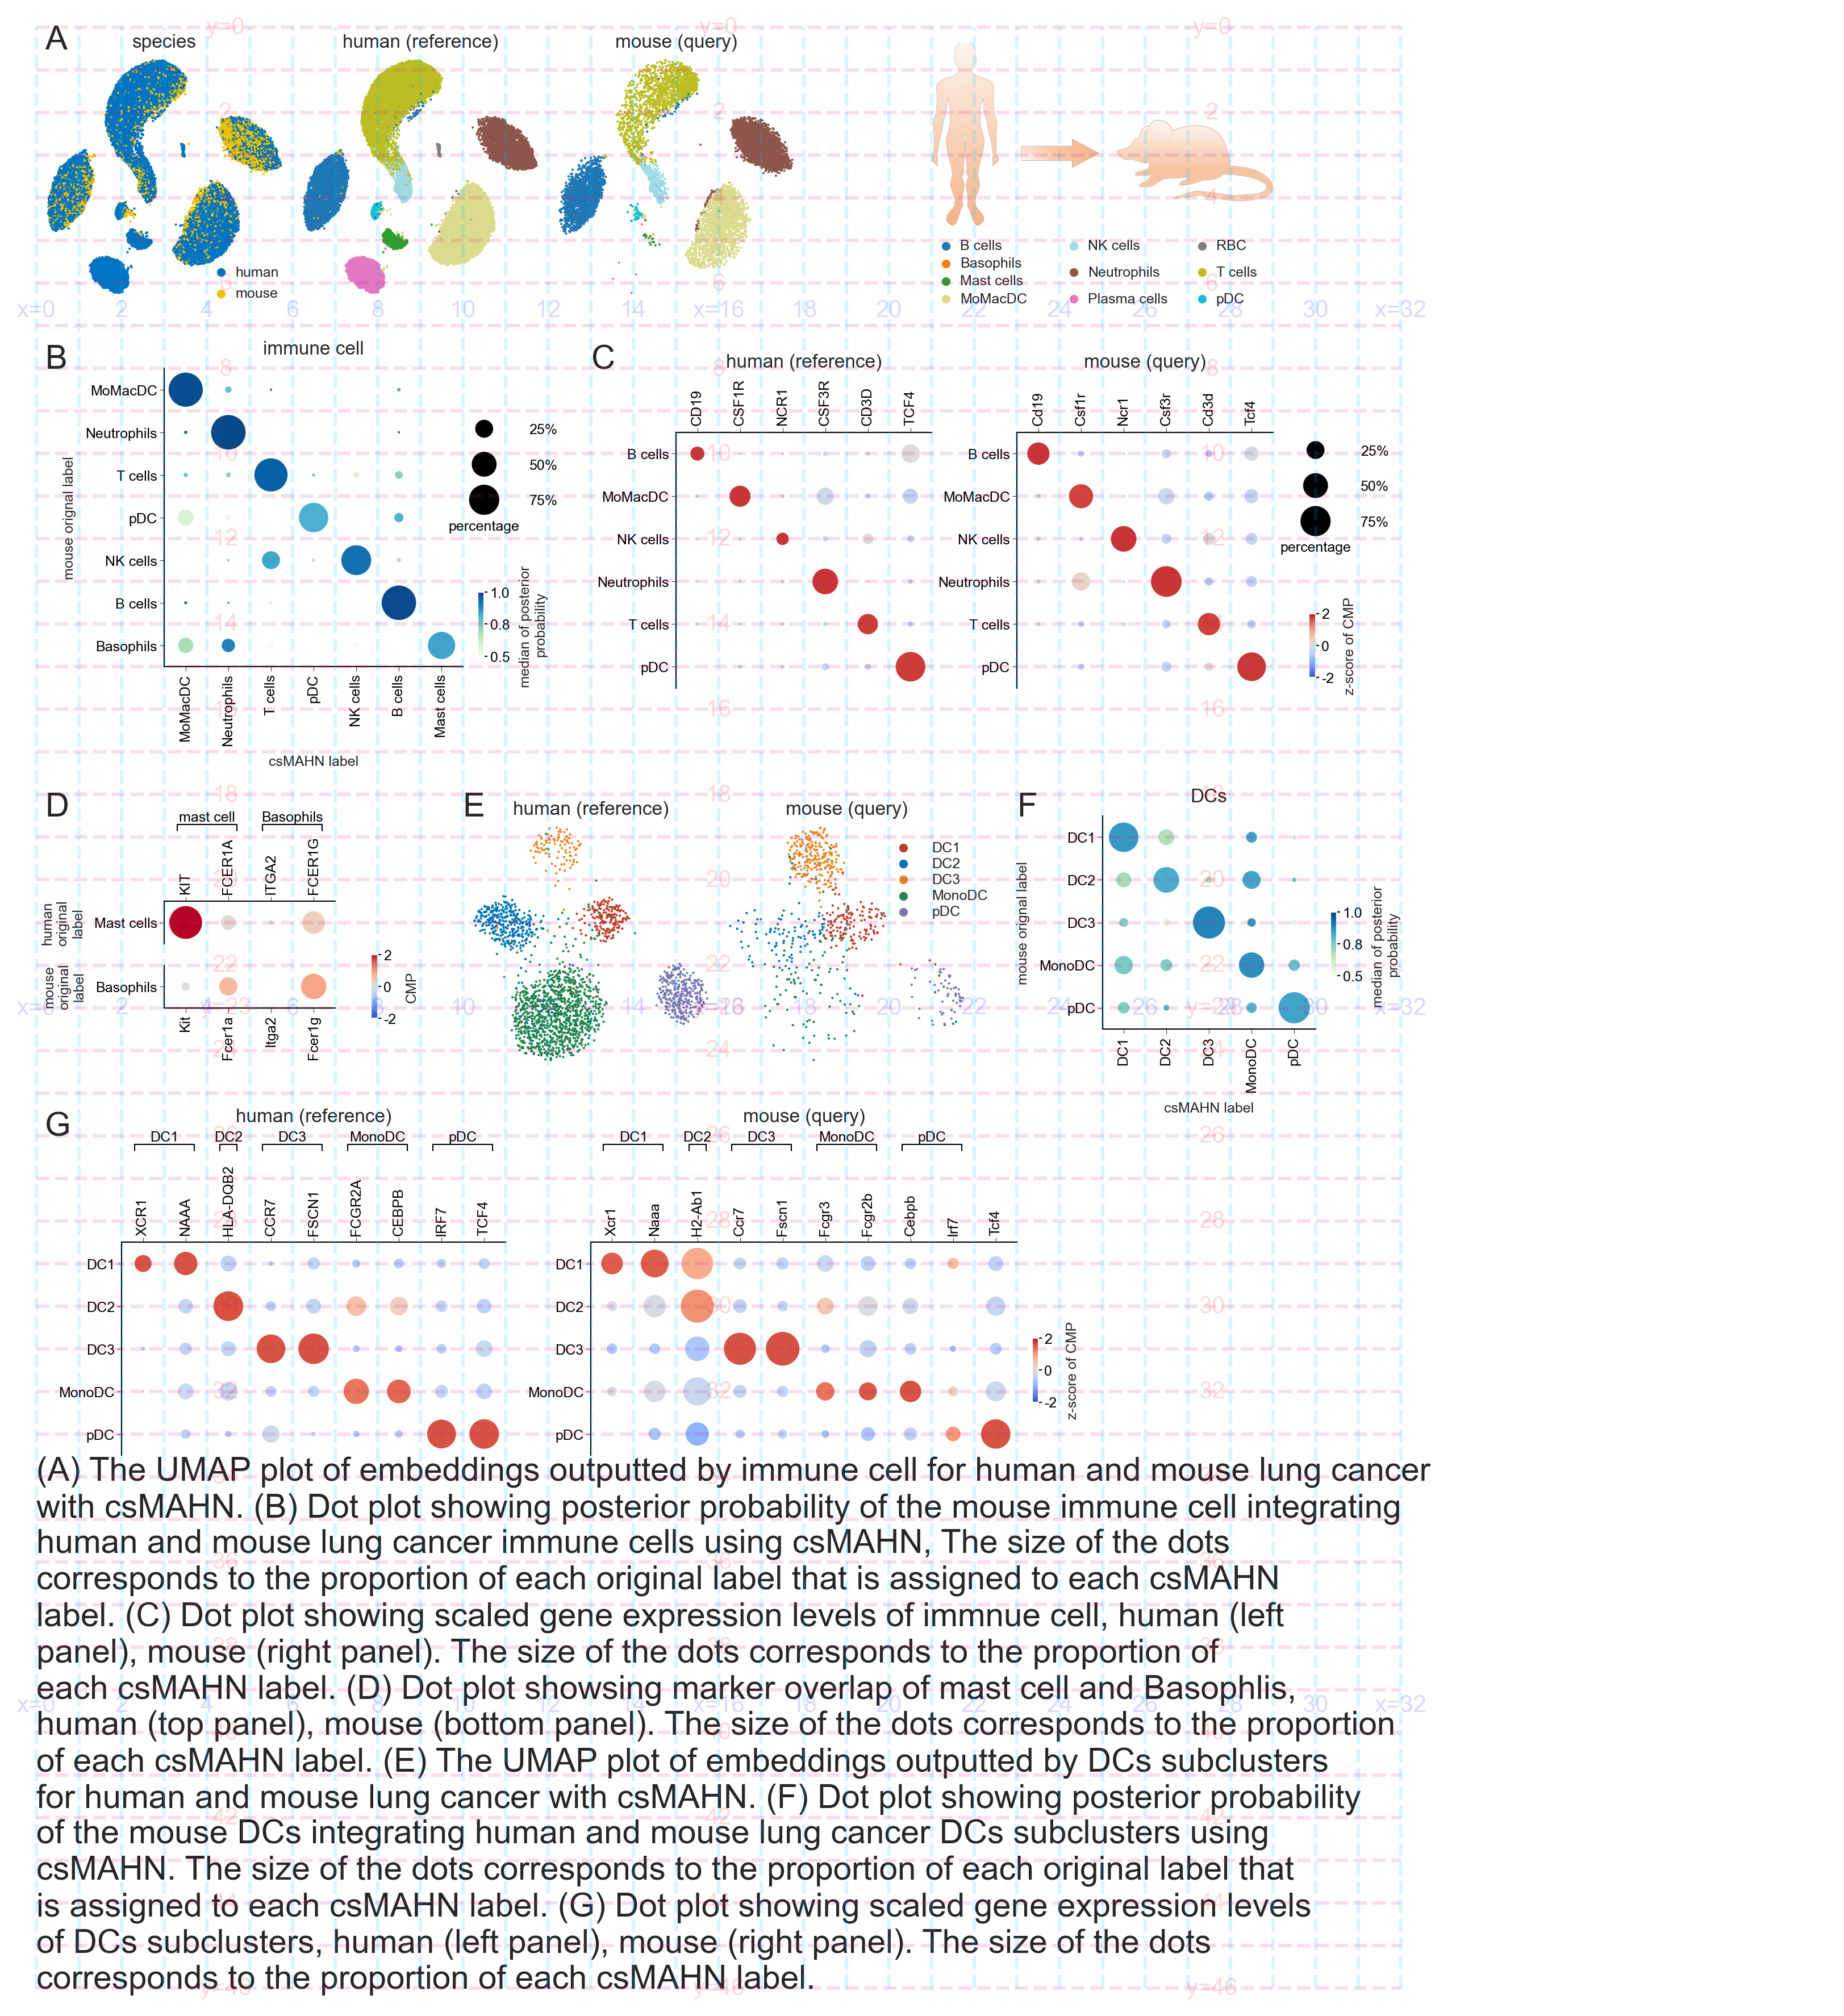

In [10]:
plt.close('all')
a4p = pl.figure.A4Page()
y = 1
# LCall----------------------------------------
y = .5
with Block('UMAP LCall', context=dict(x=0, y=y, ct='LCall', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    with Block('UMAP'):
        ax = a4p.add_ax(context.x, context.y, 6, 6)
        ut.sc.pl.umap(adata, 'sp', ax, cmap=ppara_cmap['sp'], size=context.size)
        ax.set_rasterized(True)
        ax.set_title('species', y=.95)

        ax = a4p.add_ax(context.x+6, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'ref'),
                      'model_label', ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('human (reference)', y=.95)

        ax = a4p.add_ax(context.x+12, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'que'),
                      'model_label', ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('mouse (query)', y=.95)
        del ax
    with Block('UMAP legend'):
        ax = a4p.add_ax(context.x+4, context.y+5, 2, 1)
        pl.cmap.show(ppara_cmap['sp'], ax=ax, text_x=.05)
        a4p.area_update(context.x+21, context.y+4, 1, 3, 2, 2.5, gap_width=1)
        # a4p.area_show()
        for ax, keys in zip(a4p.area_yield_ax(), np.array_split(list(cmap.keys()), 3)):
            pl.cmap.show(subset_dict(cmap, keys), ax=ax, text_x=.05)
        del ax, keys
    with Block('logo'):
        ax = a4p.add_ax(21, 0, 8, 5)
        ax.imshow(plt.imread(p_pdf.joinpath('1.png')))
        ax.set_axis_off()
    del row, cmap, adata
y = y + 9
with Block('posterior probability imm',
           context=dict(x=3, y=y-1.5, cmap='GnBu', item='LCall')) as context:
    kw_cbar = dict(format='{x:.1f}', aspect=10, label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='MoMacDC,Neutrophils,T cells,pDC,NK cells,B cells,Mast cells'.split(','),
        order_row='MoMacDC,Neutrophils,T cells,pDC,NK cells,B cells,Basophils'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('immune cell')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')

    ax = a4p.add_ax(context.x+6.5, context.y+1, 2, 2.5, rc=update_dict(pl.rc_blank,
                                                                       {'ytick.labelright': True, 'xtick.labelbottom': True}))
    dotplot_marker_legend(ax, draw_cbar=False)
    ax = a4p.add_ax(context.x+6.5, context.y+5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar, kw_cbar

with Block('marker LCall', context=dict(x=15, y=y, ct='LCall', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label', transpose=True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))
    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(marker_dict['ref'].values()),
                     order=list(marker_dict['ref'].keys()))
        ax = a4p.add_ax(context.x, context.y, 6, 6, rc=pl.rc_frame_lt)
        ax.set_title('human (reference)', y=1.2)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 8
    with Block('que'):
        ax = a4p.add_ax(context.x, context.y, 6, 6, rc=pl.rc_frame_lt)
        ax.set_title('mouse (query)', y=1.2)
        ppara.update(adata=adata_que,
                     genes=list(marker_dict['que'].values()),
                     order=list(marker_dict['que'].keys()))
        cbar = dotplot_marker(ax=ax, **ppara)

    context.x += 6
    with Block('legend'):
        ax = a4p.add_ax(context.x, context.y, 2, 2.5, rc=update_dict(pl.rc_blank, {
            'ytick.labelright': True, 'xtick.labelbottom': True}))
        dotplot_marker_legend(ax, draw_cbar=False)

        ax = a4p.add_ax(context.x, context.y+4, 1, 2, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
        
    context.x += 6
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara
y = y + 9

with Block('marker LCall marker of Mast cells, Basophils', context=dict(
        x=3, y=y, ct='LCall', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label', transpose=True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))
    with Block('marker of Mast cells, Basophils'):
        ax = a4p.add_ax(context.x, context.y, 5, 1, rc=pl.rc_blank)
        ax.set_xlim(0, 5), ax.set_ylim(0, 1)
        pl.tl_stats_bar(ax, [0+.3, 2-.3], text='mast cell', bottom=.65, top=.8)
        pl.tl_stats_bar(ax, [2+.3, 4-.3], text='Basophils', bottom=.65, top=.8)
        context.y += 2
        ppara.update(adata=adata_ref,
                     genes='KIT,FCER1A,ITGA2,FCER1G'.split(','),
                     order='Mast cells')
        ax = a4p.add_ax(context.x, context.y, 4, 1, rc=pl.rc_frame_lt)
        ax.set_ylabel('human\noriginal\nlabel')
        cbar = dotplot_marker(ax=ax, zscore=False, **ppara)

        ax = a4p.add_ax(context.x, context.y+1.5, 4, 1, rc=pl.rc_frame)
        ax.set_ylabel('mouse\noriginal\nlabel')
        ppara.update(adata=adata_que, key_group='true_label',
                     genes='Kit,Fcer1a,Itga2,Fcer1g'.split(','),
                     order='Basophils')
        cbar = dotplot_marker(ax=ax, zscore=False, **ppara)
        # cbar
        ax = a4p.add_ax(context.x+4, context.y+1, 1, 2, rc=pl.rc_blank)
        kw_cbar.update(label='CMP')
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row,cmap,adata,marker_dict,adata_ref,adata_que,kw_cbar,ppara

# LCDCs ----------------------------------------
with Block('UMAP LCDCs', context=dict(x=10, y=y, ct='LCDCs', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    adata = ppara_adata[context.ct]
    cmap = ppara_cmap[context.ct]
    with Block('UMAP'):
        ax = a4p.add_ax(context.x, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'ref'), 'model_label',
                      ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('human (reference)', y=.95)

        ax = a4p.add_ax(context.x+6, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'que'), 'model_label',
                      ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('mouse (query)', y=.95)

        ax = a4p.add_ax(context.x+10, context.y, 2, 3)
        pl.cmap.show(cmap, ax=ax)

    del row, adata, cmap, ax

with Block('posterior probability DCs', context=dict(x=25, y=y,
    cmap='GnBu', item='LCDCs')) as context:
    kw_cbar=dict(format='{x:.1f}', aspect=10,label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='DC1,DC2,DC3,MonoDC,pDC'.split(','),
        order_row='DC1,DC2,DC3,MonoDC,pDC'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('DCs')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')

    ax = a4p.add_ax(context.x+4.5, context.y+2, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar,kw_cbar
y = y+7.5

with Block('marker LCDcs', context=dict(x=2, y=y, ct='LCDCs', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(
        key_group='model_label', transpose=True,
        kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order=list(marker_dict['ref'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='DC1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 3-.3], text='DC2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [3+.3, 5-.3], text='DC3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [5+.3, 7-.3], text='MonoDC', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [7+.3, 9-.3], text='pDC', bottom=.65, top=.8)
            ax.set_title('human (reference)')
        ax = a4p.add_ax(context.x, context.y+2.5, 9, 5, rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 11
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=list(np.concatenate(list(marker_dict['que'].values()))),
                     order=list(marker_dict['que'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='DC1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 3-.3], text='DC2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [3+.3, 5-.3], text='DC3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [5+.3, 7-.3], text='MonoDC', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [7+.3, 9-.3], text='pDC', bottom=.65, top=.8)
            ax.set_title('mouse (query)')
        ax = a4p.add_ax(context.x, context.y+2.5, 10, 5, rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    ax = a4p.add_ax(context.x+9.5, context.y+4.5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara

with Block('text'):
    for text, (x, y) in zip(
            [chr(65+i) for i in range(26)], np.array([
                [.2, .5], [.2, 8], [13, 8], [.2, 18.5],  # ABCD
                [10, 18.5], [23, 18.5], [.2, 26],    # EFG
            ])):
        a4p.add_text_with_ax(a4p.add_ax(x, y), text)
    del text, x, y

pl.tl_savefig(a4p.fig, '{}_{}.png'.format(item, model), p_pdf)
pl.tl_savefig(a4p.fig, '{}_{}.svg'.format(item, model), p_pdf)

with Block('note'):
    text = "(A) The UMAP plot of embeddings outputted by immune cell for human and mouse lung cancer with csMAHN. \
(B) Dot plot showing posterior probability of the mouse immune cell integrating human and mouse lung cancer immune cells using csMAHN, \
The size of the dots corresponds to the proportion of each original label that is assigned to each csMAHN label. \
(C) Dot plot showing scaled gene expression levels of immnue cell, human (left panel), mouse (right panel). \
The size of the dots corresponds to the proportion of each csMAHN label. \
(D) Dot plot showsing marker overlap of mast cell and Basophlis, human (top panel), mouse (bottom panel). \
The size of the dots corresponds to the proportion of each csMAHN label. \
(E) The UMAP plot of embeddings outputted by DCs subclusters for human and mouse lung cancer with csMAHN. \
(F) Dot plot showing posterior probability of the mouse DCs integrating human and mouse lung cancer DCs subclusters using csMAHN. \
The size of the dots corresponds to the proportion of each original label that is assigned to each csMAHN label. \
(G) Dot plot showing scaled gene expression levels of DCs subclusters, human (left panel), mouse (right panel). \
The size of the dots corresponds to the proportion of each csMAHN label. \
"
    text = pl.tl_str_next_line(text, 85, ' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42), text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text
a4p.save_as_pdf(p_pdf.joinpath('{}_{}.pdf'.format(item, model)))
a4p.add_grid()
a4p.fig

## supp

[out][plot] LC_csMAHN_supp.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] LC_csMAHN_supp.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
(A) The UMAP plot of embeddings outputted by monocyte subclusters for human
and mouse lung cancer with csMAHN. (B) dot plot showing posterior probability
of the mouse monocyte integrating human and mouse lung cancer monocyte subclusters
using csMAHN. The size of the dots corresponds to the proportion
of each original label that is assigned to each csMAHN label. (C) dot plot
showing scaled gene expression levels of monocyte subclusters, human (top
panel), mouse (bottom panel). (D) The UMAP plot of embeddings outputted by
neutrophils subclusters for human and mouse lung cancer with csMAHN. (E) dot
plot showing posterior probability of the mouse neutrophils integrating human
and mouse lung cancer neutrophilss subclusters using csMA

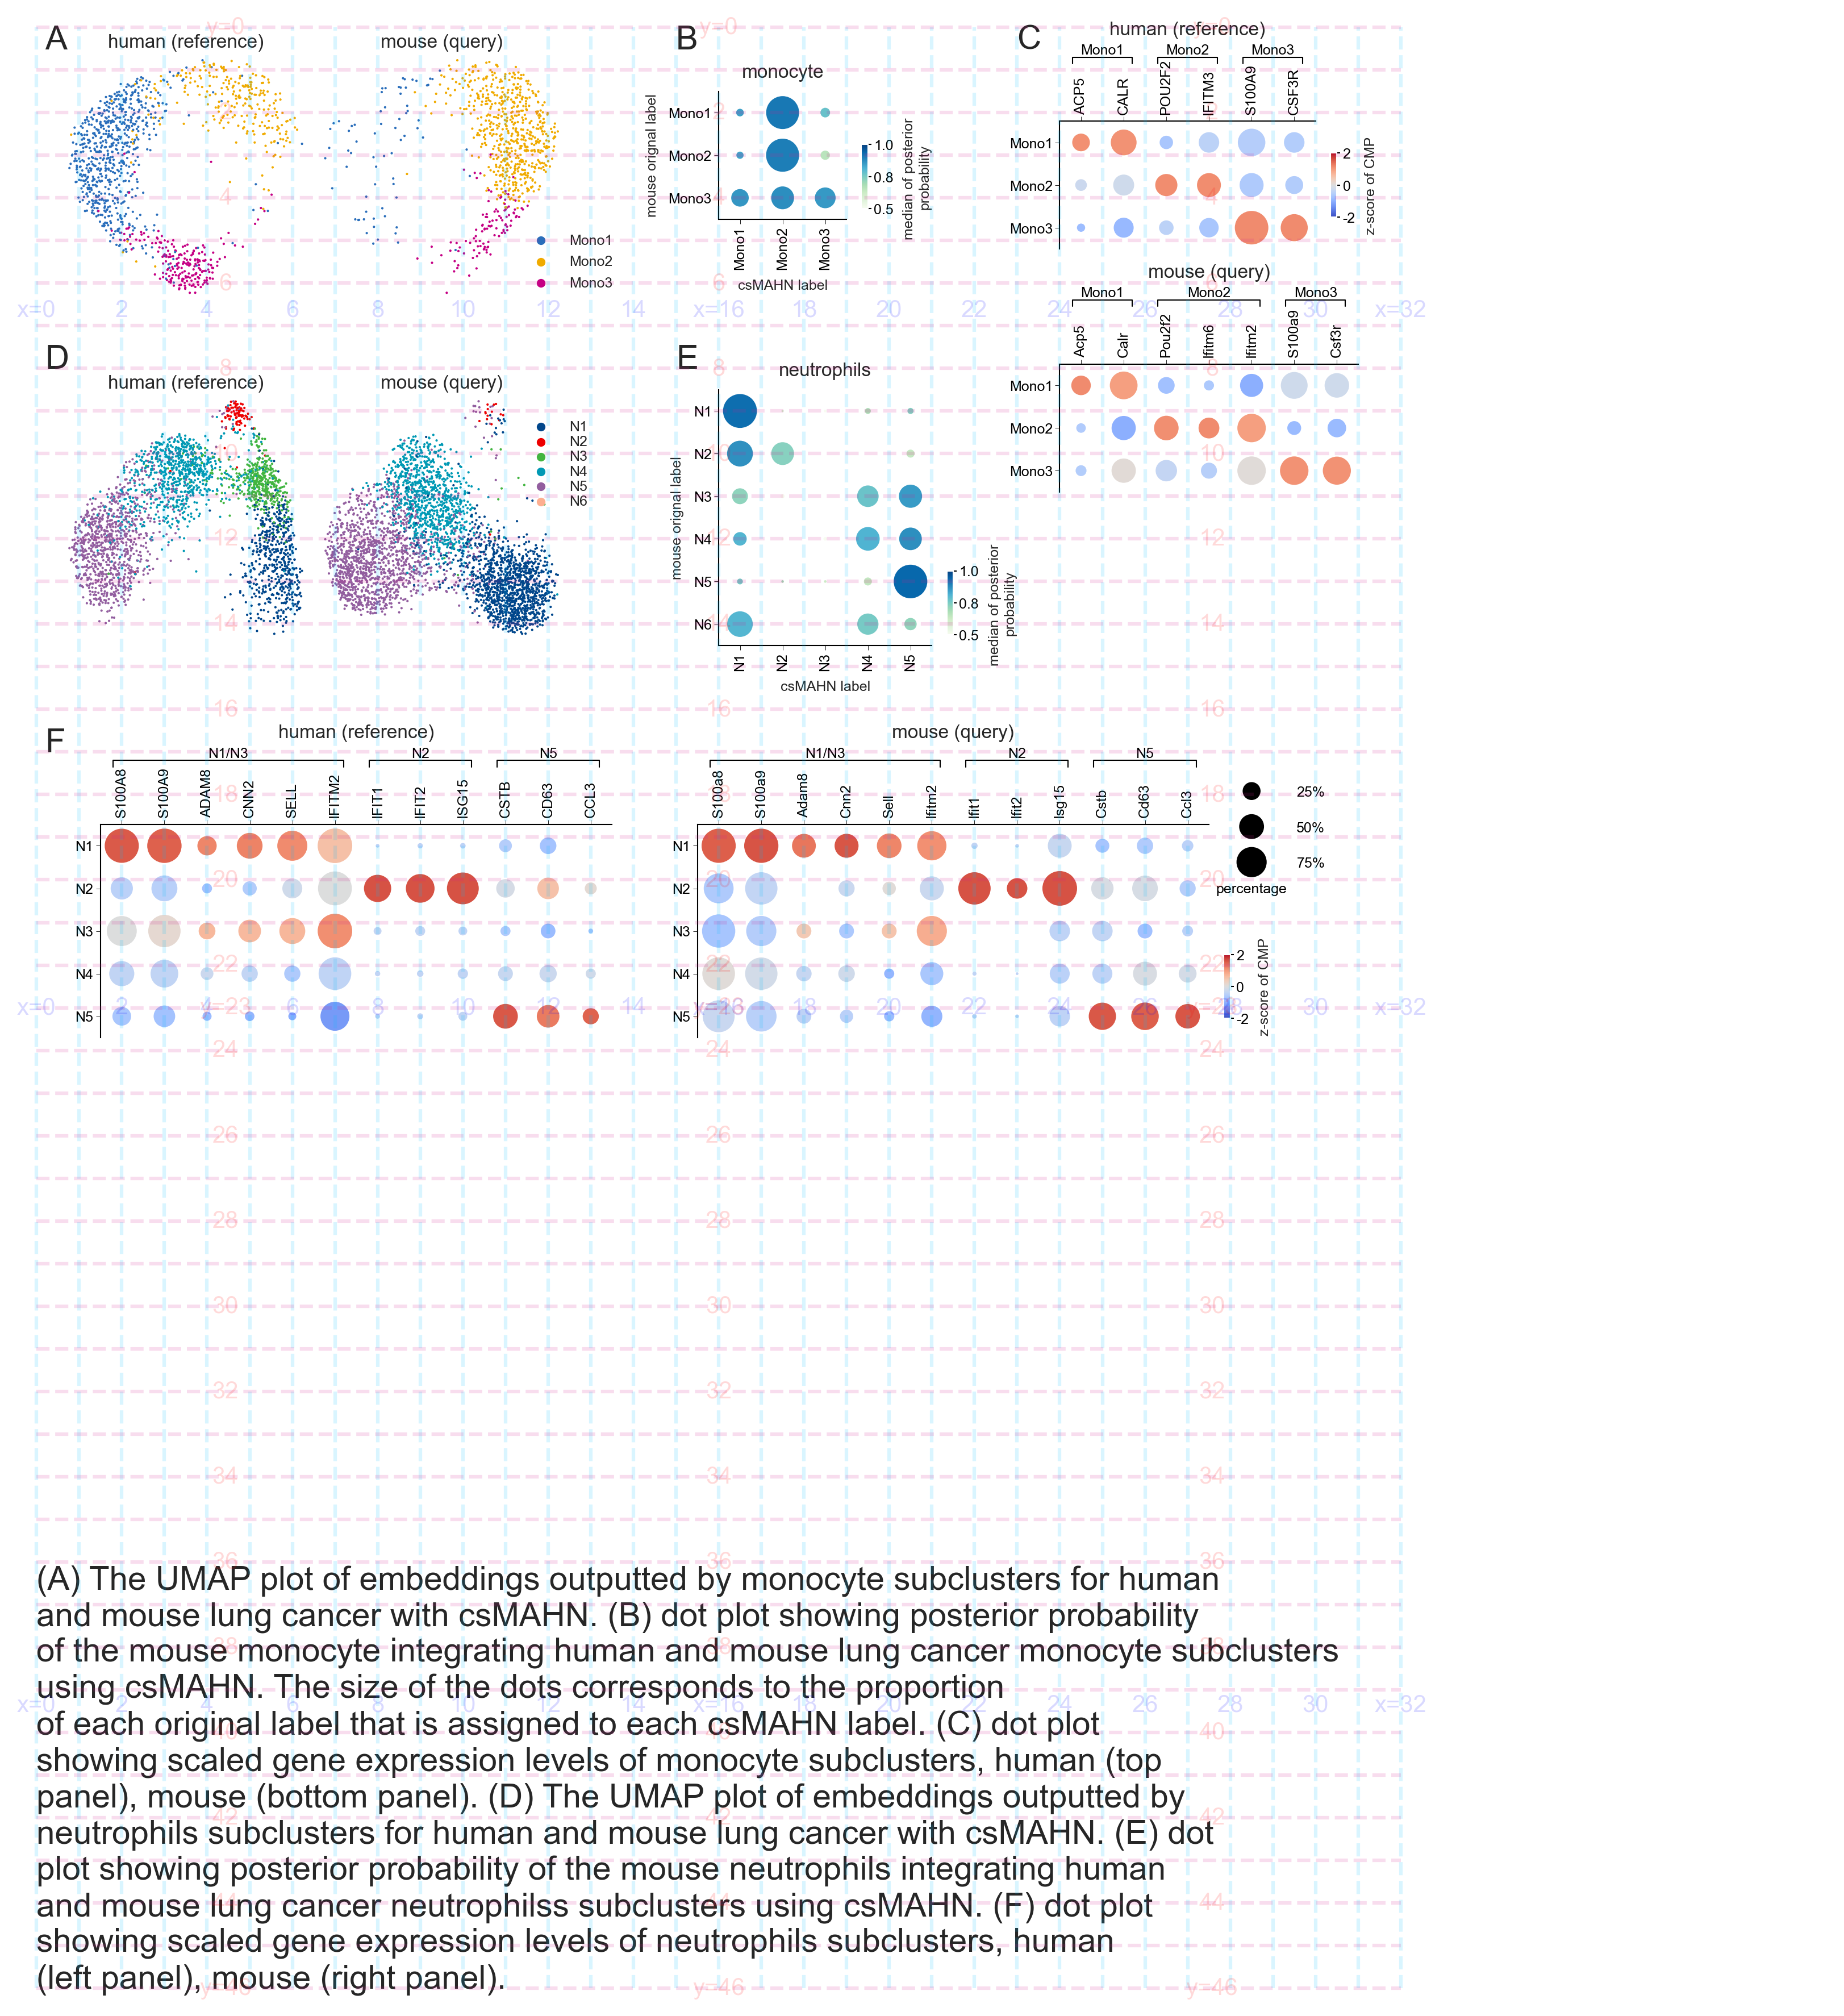

In [11]:
plt.close('all')
a4p = pl.figure.A4Page()

y = .5
# LCMono ----------------------------------------
with Block('UMAP Mono', context=dict(x=.5, y=y, ct='LCMono', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    adata = ppara_adata[context.ct]
    cmap = ppara_cmap[context.ct]
    with Block('UMAP'):
        ax = a4p.add_ax(context.x, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'ref'), 'model_label',
                      ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('human (reference)', y=.95)

        ax = a4p.add_ax(context.x+6, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'que'), 'model_label',
                      ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('mouse (query)', y=.95)

        ax = a4p.add_ax(context.x+11, context.y+4, 2, 2)
        pl.cmap.show(cmap, ax=ax)

    del row, adata, cmap, ax

with Block('posterior probability Mono', context=dict(x=16, y=y+1,cmap='GnBu', item='LCMono')) as context:
    kw_cbar=dict(format='{x:.1f}', aspect=10,label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='Mono1,Mono2,Mono3'.split(','),
        order_row='Mono1,Mono2,Mono3'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('monocyte')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')
    ax = a4p.add_ax(context.x+2.5, context.y+1, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar,kw_cbar

with Block('marker Mono', context=dict(x=24, y=y, ct='LCMono', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label', transpose=True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order=list(marker_dict['ref'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='Mono1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 4-.3], text='Mono2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [4+.3, 6-.3], text='Mono3', bottom=.65, top=.8)
            ax.set_title('human (reference)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.y += 5.7
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=list(np.concatenate(list(marker_dict['que'].values()))),
                     order=list(marker_dict['que'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='Mono1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 5-.3], text='Mono2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [5+.3, 7-.3], text='Mono3', bottom=.65, top=.8)
            ax.set_title('mouse (query)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    ax = a4p.add_ax(context.x+5.5, context.y-3.5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara
y += 8
# LCNeu ----------------------------------------
with Block('UMAP Neu', context=dict(x=.5, y=y, ct='LCNeu', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    adata = ppara_adata[context.ct]
    cmap = ppara_cmap[context.ct]
    with Block('UMAP'):
        ax = a4p.add_ax(context.x, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'ref'), 'model_label',
                      ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('human (reference)', y=.95)

        ax = a4p.add_ax(context.x+6, context.y, 6, 6)
        ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'que'), 'model_label',
                      ax=ax, cmap=cmap, size=context.size)
        ax.set_rasterized(True)
        ax.set_title('mouse (query)', y=.95)

        ax = a4p.add_ax(context.x+11, context.y, 2, 3.5)
        pl.cmap.show(cmap, ax=ax)
    del row, adata, cmap, ax

with Block('posterior probability Neu', context=dict(x=16, y=y,cmap='GnBu', item='LCNeu')) as context:
    kw_cbar=dict(format='{x:.1f}', aspect=10,label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='N1,N2,N3,N4,N5'.split(','),
        order_row='N1,N2,N3,N4,N5,N6'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('neutrophils')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')
    
    ax = a4p.add_ax(context.x+4.5, context.y+4, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar, kw_cbar
y += 8.5
with Block('marker Neu', context=dict(x=1.5, y=y, ct='LCNeu', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(
        key_group='model_label',
        transpose=True,
        kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order=['N{}'.format(i+1) for i in range(5)])
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 6-.3], text='N1/N3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [6+.3, 9-.3], text='N2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [9+.3, 12-.3], text='N5', bottom=.65, top=.8)
            ax.set_title('human (reference)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    context.x += 14
    with Block('que'):
        ppara.update(adata=adata_que, genes=list(np.concatenate(list(marker_dict['que'].values()))))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 6-.3], text='N1/N3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [6+.3, 9-.3], text='N2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [9+.3, 12-.3], text='N5', bottom=.65, top=.8)
            ax.set_title('mouse (query)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    with Block('legend'):
        ax = a4p.add_ax(context.x+12, context.y+.5, 2, 2.5, rc=update_dict(pl.rc_blank, {
            'ytick.labelright': True, 'xtick.labelbottom': True}))
        dotplot_marker_legend(ax, draw_cbar=False)

        ax = a4p.add_ax(context.x+11.5, context.y+4.5, 1, 2, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
        del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara

with Block('text'):
    for text, (x, y) in zip(
            [chr(65+i) for i in range(26)], np.array([
                [.2, .5], [15, .5], [23, .5], [.2, 8],  # ABCD
                [15, 8], [.2, 17],    # EF
            ])):
        a4p.add_text_with_ax(a4p.add_ax(x, y), text)
    del text, x, y

pl.tl_savefig(a4p.fig, '{}_{}_supp.png'.format(item, model), p_pdf)
pl.tl_savefig(a4p.fig, '{}_{}_supp.svg'.format(item, model), p_pdf)

with Block('note'):
    text = "\
(A) The UMAP plot of embeddings outputted by monocyte subclusters for human and mouse lung cancer with csMAHN. \
(B) dot plot showing posterior probability of the mouse monocyte integrating human and mouse lung cancer monocyte subclusters using csMAHN. \
The size of the dots corresponds to the proportion of each original label that is assigned to each csMAHN label. \
(C) dot plot showing scaled gene expression levels of monocyte subclusters, human (top panel), mouse (bottom panel). \
(D) The UMAP plot of embeddings outputted by neutrophils subclusters for human and mouse lung cancer with csMAHN. \
(E) dot plot showing posterior probability of the mouse neutrophils integrating human and mouse lung cancer neutrophilss subclusters using csMAHN. \
(F) dot plot showing scaled gene expression levels of neutrophils subclusters, human (left panel), mouse (right panel). \
"
    text = pl.tl_str_next_line(text, 75, ' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42), text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))

a4p.save_as_pdf(p_pdf.joinpath('{}_{}_supp.pdf'.format(item, model)))
a4p.add_grid()
a4p.fig

## marker
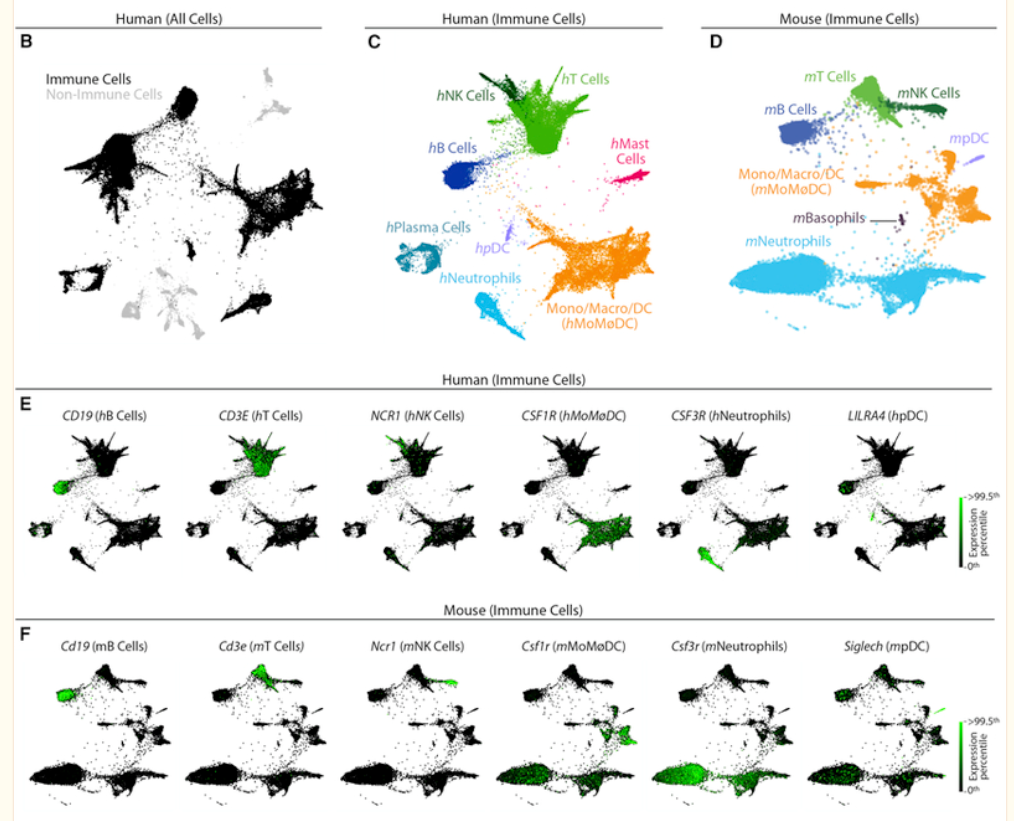

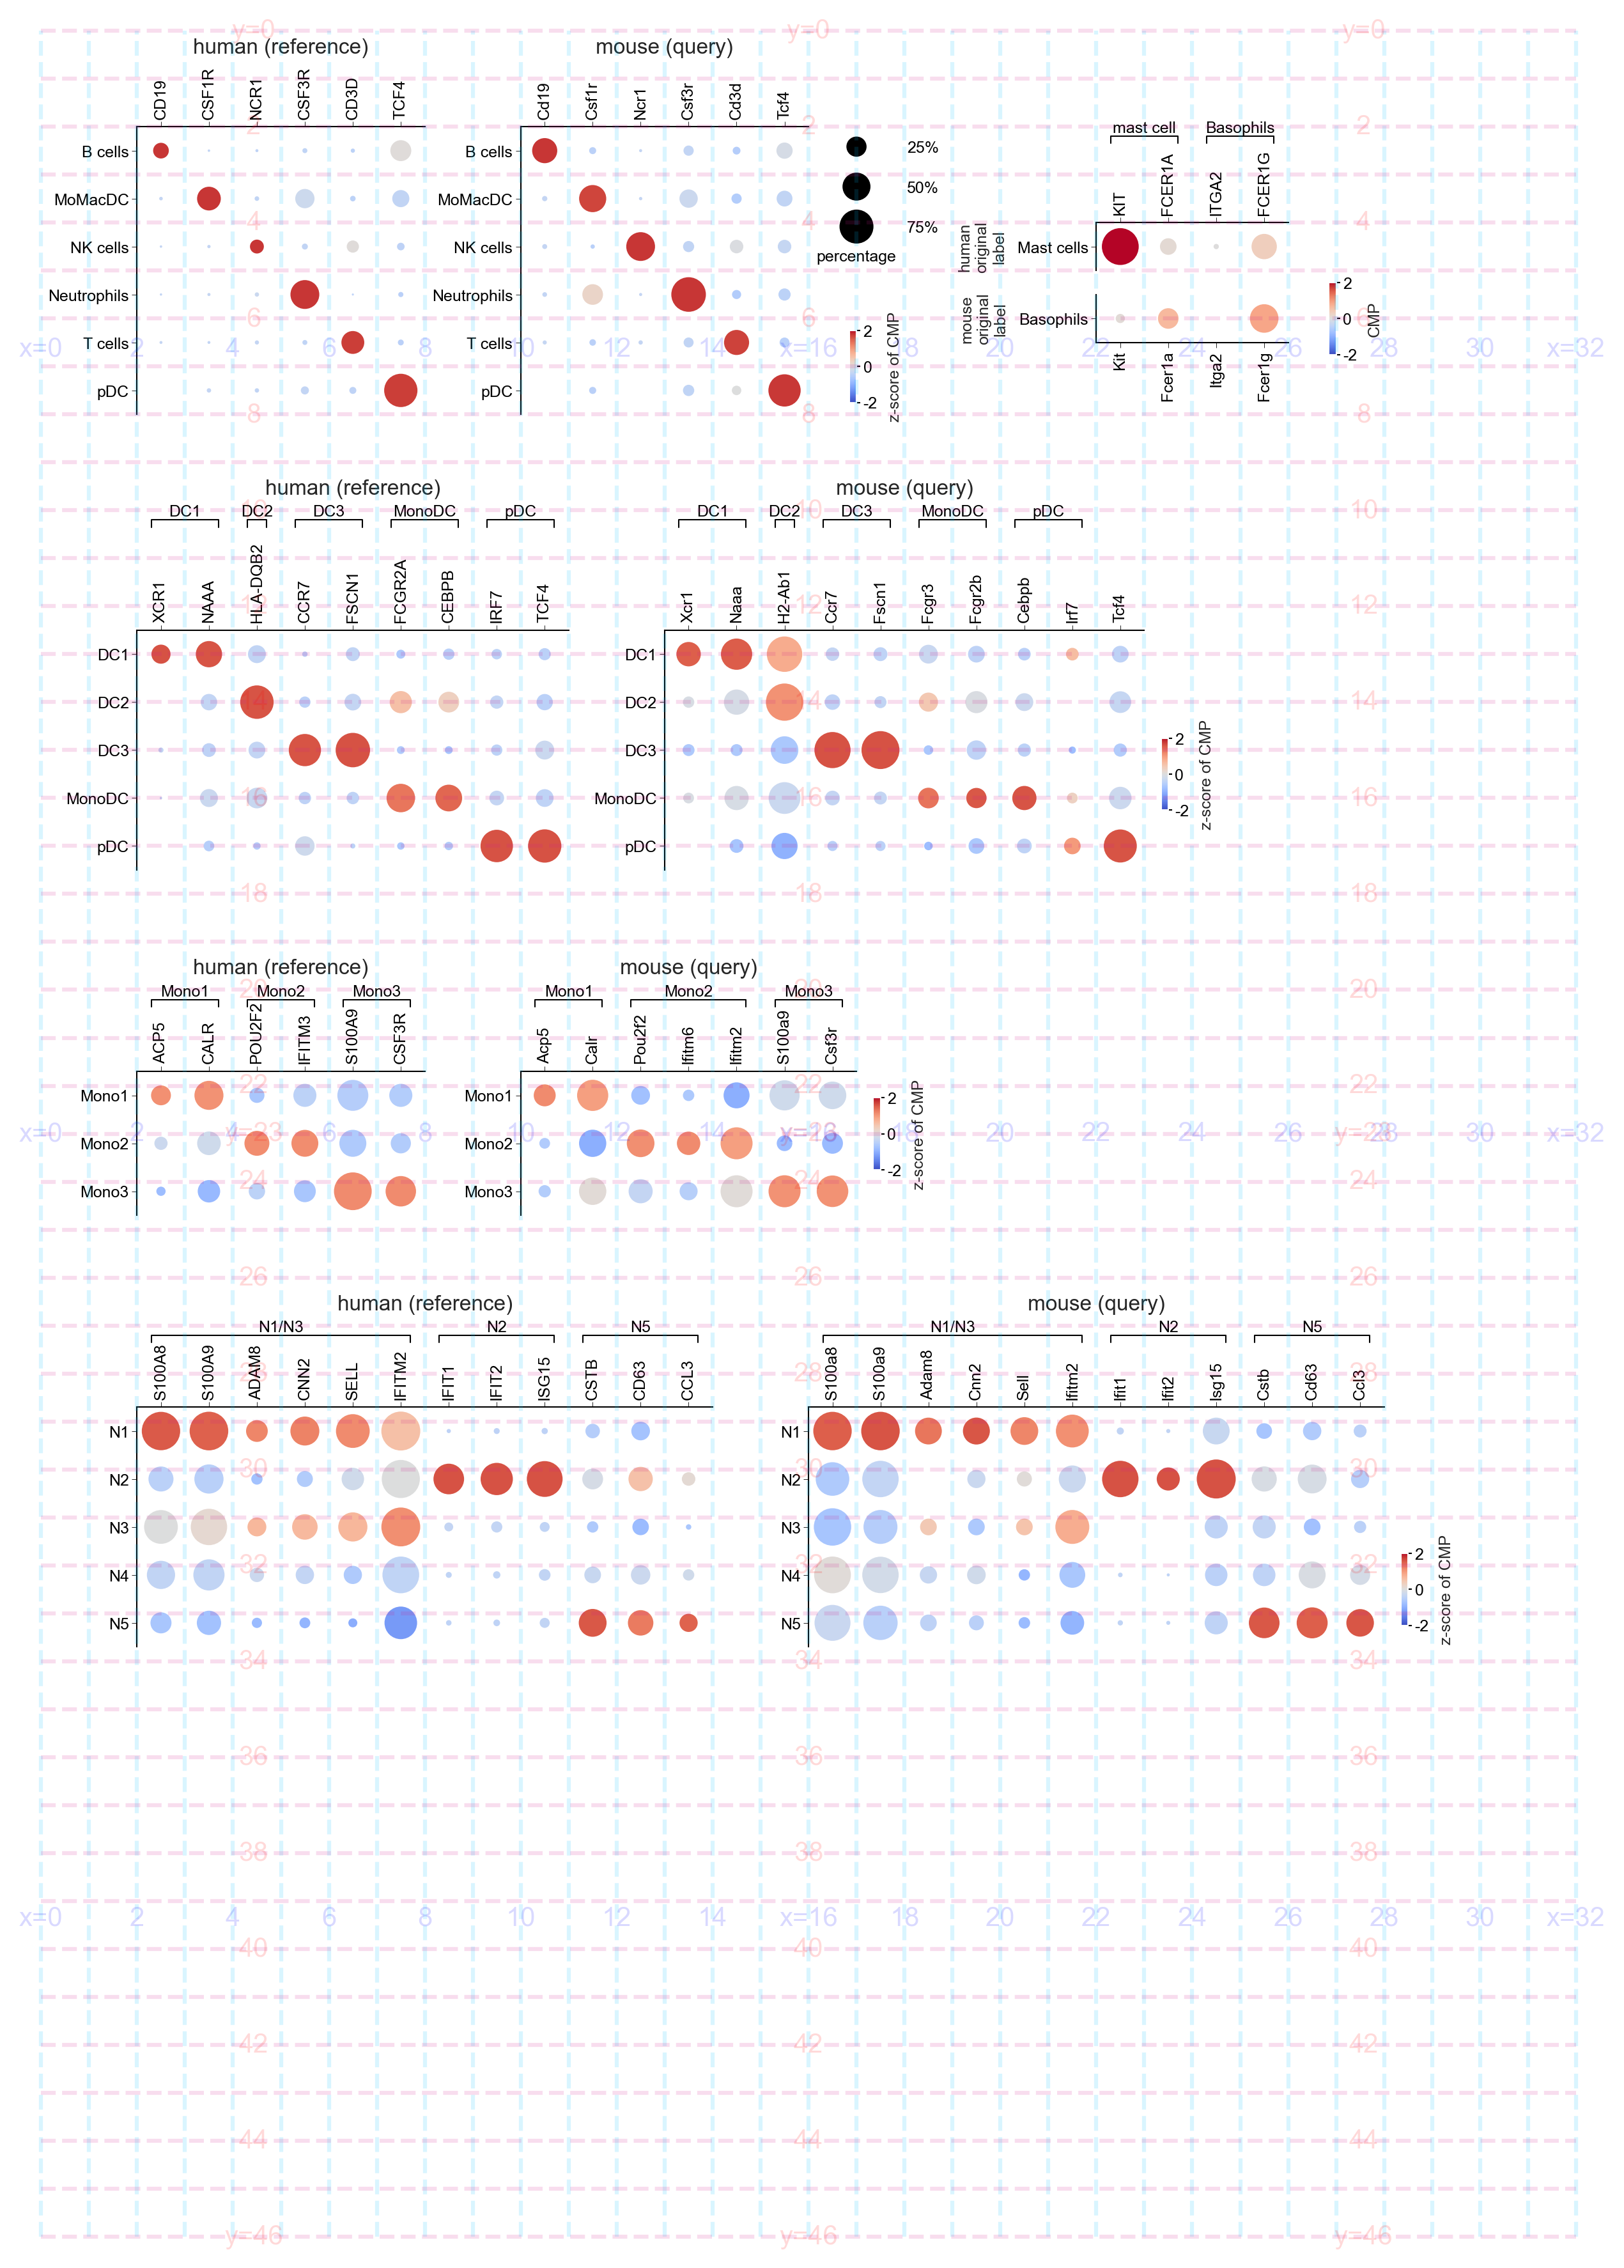

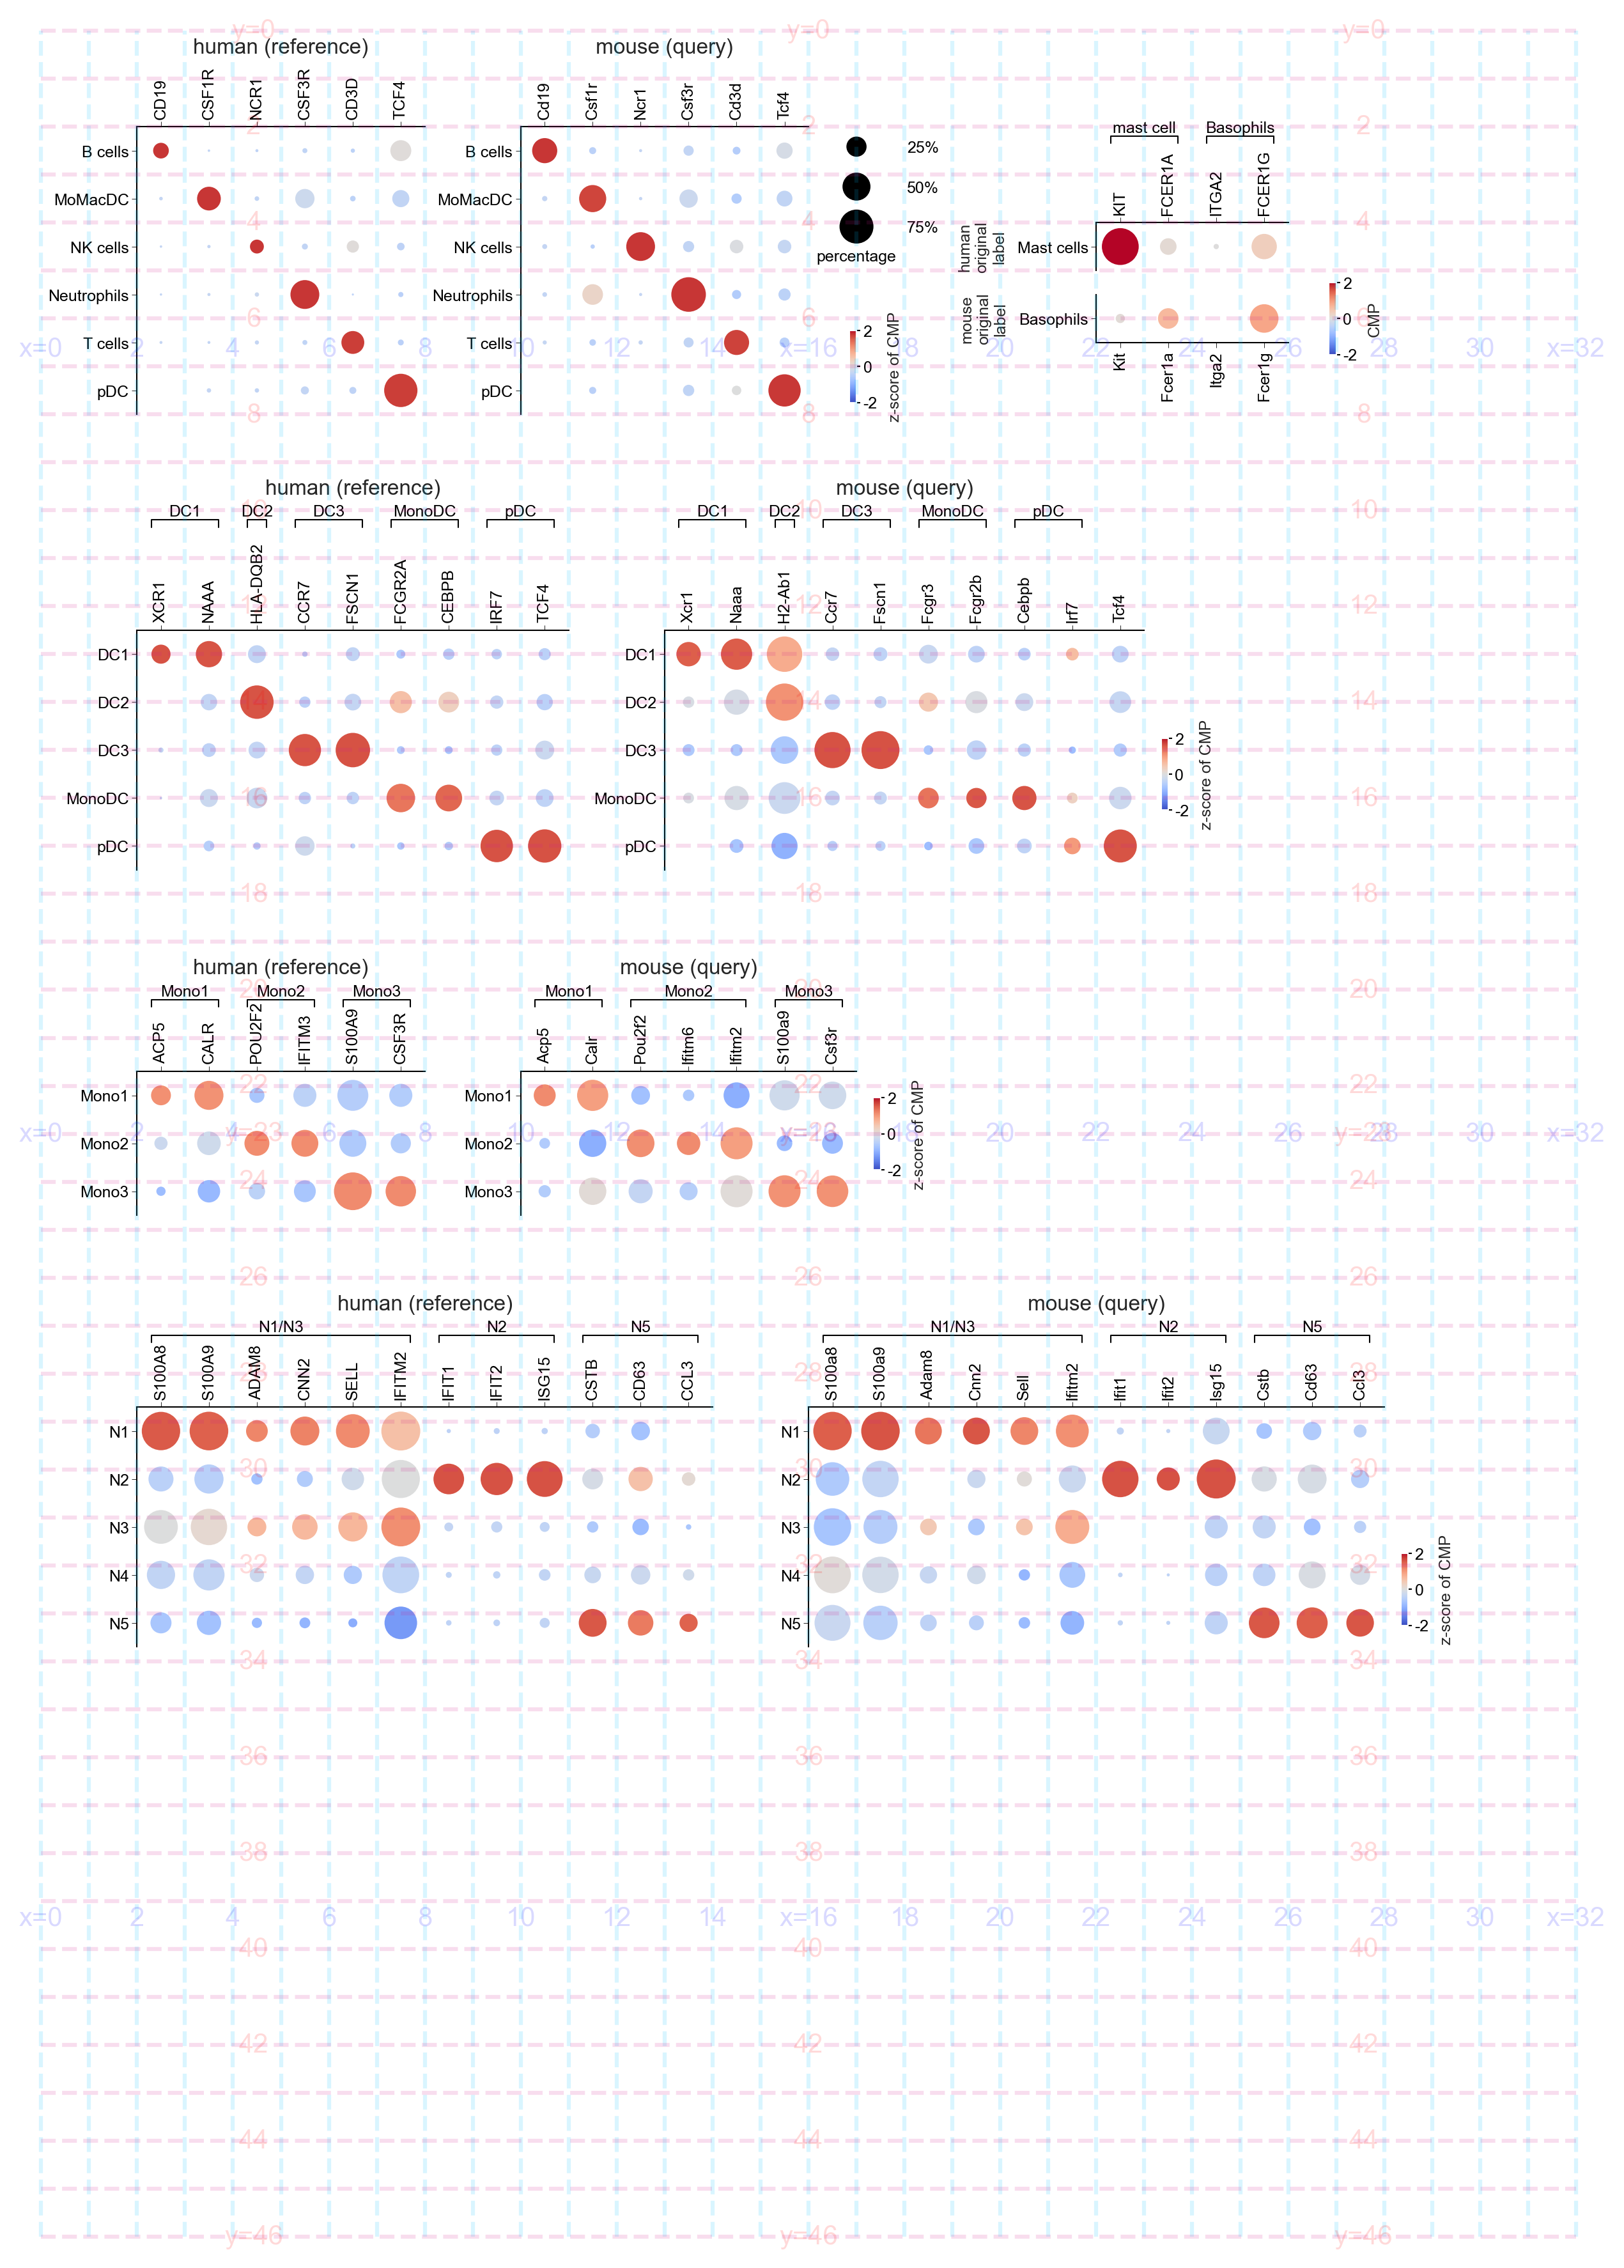

In [12]:
plt.close("all")
a4p = pl.figure.A4Page()
# LCall----------------------------------------
y = 2
with Block('marker LCall', context=dict(x=2, y=y, ct='LCall', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label', transpose=True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))
    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(marker_dict['ref'].values()),
                     order=list(marker_dict['ref'].keys()))
        ax = a4p.add_ax(context.x, context.y, 6, 6, rc=pl.rc_frame_lt)
        ax.set_title('human (reference)', y=1.2)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 8
    with Block('que'):
        ax = a4p.add_ax(context.x, context.y, 6, 6, rc=pl.rc_frame_lt)
        ax.set_title('mouse (query)', y=1.2)
        ppara.update(adata=adata_que,
                     genes=list(marker_dict['que'].values()),
                     order=list(marker_dict['que'].keys()))
        cbar = dotplot_marker(ax=ax, **ppara)

    context.x += 6
    with Block('legend'):
        ax = a4p.add_ax(context.x, context.y, 2, 2.5, rc=update_dict(pl.rc_blank, {
            'ytick.labelright': True, 'xtick.labelbottom': True}))
        dotplot_marker_legend(ax, draw_cbar=False)

        ax = a4p.add_ax(context.x, context.y+4, 1, 2, rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')

    context.x += 6
    with Block('marker of Mast cells, Basophils'):
        ax = a4p.add_ax(context.x, context.y, 5, 1, rc=pl.rc_blank)
        ax.set_xlim(0, 5), ax.set_ylim(0, 1)
        pl.tl_stats_bar(ax, [0+.3, 2-.3], text='mast cell', bottom=.65, top=.8)
        pl.tl_stats_bar(ax, [2+.3, 4-.3], text='Basophils', bottom=.65, top=.8)
        context.y += 2
        ppara.update(adata=adata_ref,
                     genes='KIT,FCER1A,ITGA2,FCER1G'.split(','),
                     order='Mast cells')
        ax = a4p.add_ax(context.x, context.y, 4, 1, rc=pl.rc_frame_lt)
        ax.set_ylabel('human\noriginal\nlabel')
        cbar = dotplot_marker(ax=ax, zscore=False, **ppara)

        ax = a4p.add_ax(context.x, context.y+1.5, 4, 1, rc=pl.rc_frame)
        ax.set_ylabel('mouse\noriginal\nlabel')
        ppara.update(adata=adata_que, key_group='true_label',
                     genes='Kit,Fcer1a,Itga2,Fcer1g'.split(','),
                     order='Basophils')
        cbar = dotplot_marker(ax=ax, zscore=False, **ppara)
        # cbar
        ax = a4p.add_ax(context.x+4, context.y+1, 1, 2, rc=pl.rc_blank)
        kw_cbar.update(label='CMP')
        cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara
y += 8
with Block('marker LCDcs', context=dict(x=2, y=y, ct='LCDCs', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(
        key_group='model_label', transpose=True,
        kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order=list(marker_dict['ref'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='DC1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 3-.3], text='DC2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [3+.3, 5-.3], text='DC3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [5+.3, 7-.3], text='MonoDC', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [7+.3, 9-.3], text='pDC', bottom=.65, top=.8)
            ax.set_title('human (reference)')
        ax = a4p.add_ax(context.x, context.y+2.5, 9, 5, rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 11
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=list(np.concatenate(list(marker_dict['que'].values()))),
                     order=list(marker_dict['que'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='DC1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 3-.3], text='DC2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [3+.3, 5-.3], text='DC3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [5+.3, 7-.3], text='MonoDC', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [7+.3, 9-.3], text='pDC', bottom=.65, top=.8)
            ax.set_title('mouse (query)')
        ax = a4p.add_ax(context.x, context.y+2.5, 10, 5, rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    ax = a4p.add_ax(context.x+9.5, context.y+4.5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara
y += 10
with Block('marker Mono', context=dict(x=2, y=y, ct='LCMono', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label', transpose=True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order=list(marker_dict['ref'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='Mono1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 4-.3], text='Mono2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [4+.3, 6-.3], text='Mono3', bottom=.65, top=.8)
            ax.set_title('human (reference)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 8
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=list(np.concatenate(list(marker_dict['que'].values()))),
                     order=list(marker_dict['que'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 2-.3], text='Mono1', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [2+.3, 5-.3], text='Mono2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [5+.3, 7-.3], text='Mono3', bottom=.65, top=.8)
            ax.set_title('mouse (query)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    ax = a4p.add_ax(context.x+6.5, context.y+2, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara
y += 7
with Block('marker Neu', context=dict(x=2, y=y, ct='LCNeu', size=1)) as context:
    row = ppara_data['res_LC'].loc['{};{}'.format(model, context.ct[2:]), :]
    cmap = ppara_cmap[context.ct]
    adata = ppara_adata[context.ct]
    marker_dict = ppara_data['marker_dotplot'][context.ct]
    adata_ref = load_normalized_adata(find_path_from_para(df_para, row['name_ref']),
                                      adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para, row['name_que']),
                                      adata.obs)
    kw_cbar = dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(
        key_group='model_label',
        transpose=True,
        kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=list(np.concatenate(list(marker_dict['ref'].values()))),
                     order=['N{}'.format(i+1) for i in range(5)])
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 6-.3], text='N1/N3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [6+.3, 9-.3], text='N2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [9+.3, 12-.3], text='N5', bottom=.65, top=.8)
            ax.set_title('human (reference)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    context.x += 14
    with Block('que'):
        ppara.update(adata=adata_que, genes=list(np.concatenate(list(marker_dict['que'].values()))))
        with Block('bar'):
            ax = a4p.add_ax(context.x, context.y, len(ppara['genes']), 1, rc=pl.rc_blank)
            ax.set_xlim(0, len(ppara['genes'])), ax.set_ylim(0, 1)
            pl.tl_stats_bar(ax, [0+.3, 6-.3], text='N1/N3', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [6+.3, 9-.3], text='N2', bottom=.65, top=.8)
            pl.tl_stats_bar(ax, [9+.3, 12-.3], text='N5', bottom=.65, top=.8)
            ax.set_title('mouse (query)')
        ax = a4p.add_ax(context.x,
                        context.y+1.7,
                        len(ppara['genes']),
                        len(ppara['order']),
                        rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)

    ax = a4p.add_ax(context.x+11.5, context.y+4.5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row, cmap, adata, marker_dict, adata_ref, adata_que, kw_cbar, ppara

# pl.tl_savefig(a4p.fig, '{}_{}_marker.svg'.format(item, model), p_pdf)
# pl.tl_savefig(a4p.fig, '{}_{}_marker.png'.format(item, model), p_pdf)

# a4p.save_as_pdf(p_pdf.joinpath('{}_{}_marker.pdf'.format(item, model)))
a4p.add_grid()
a4p.fig

## posterior probability

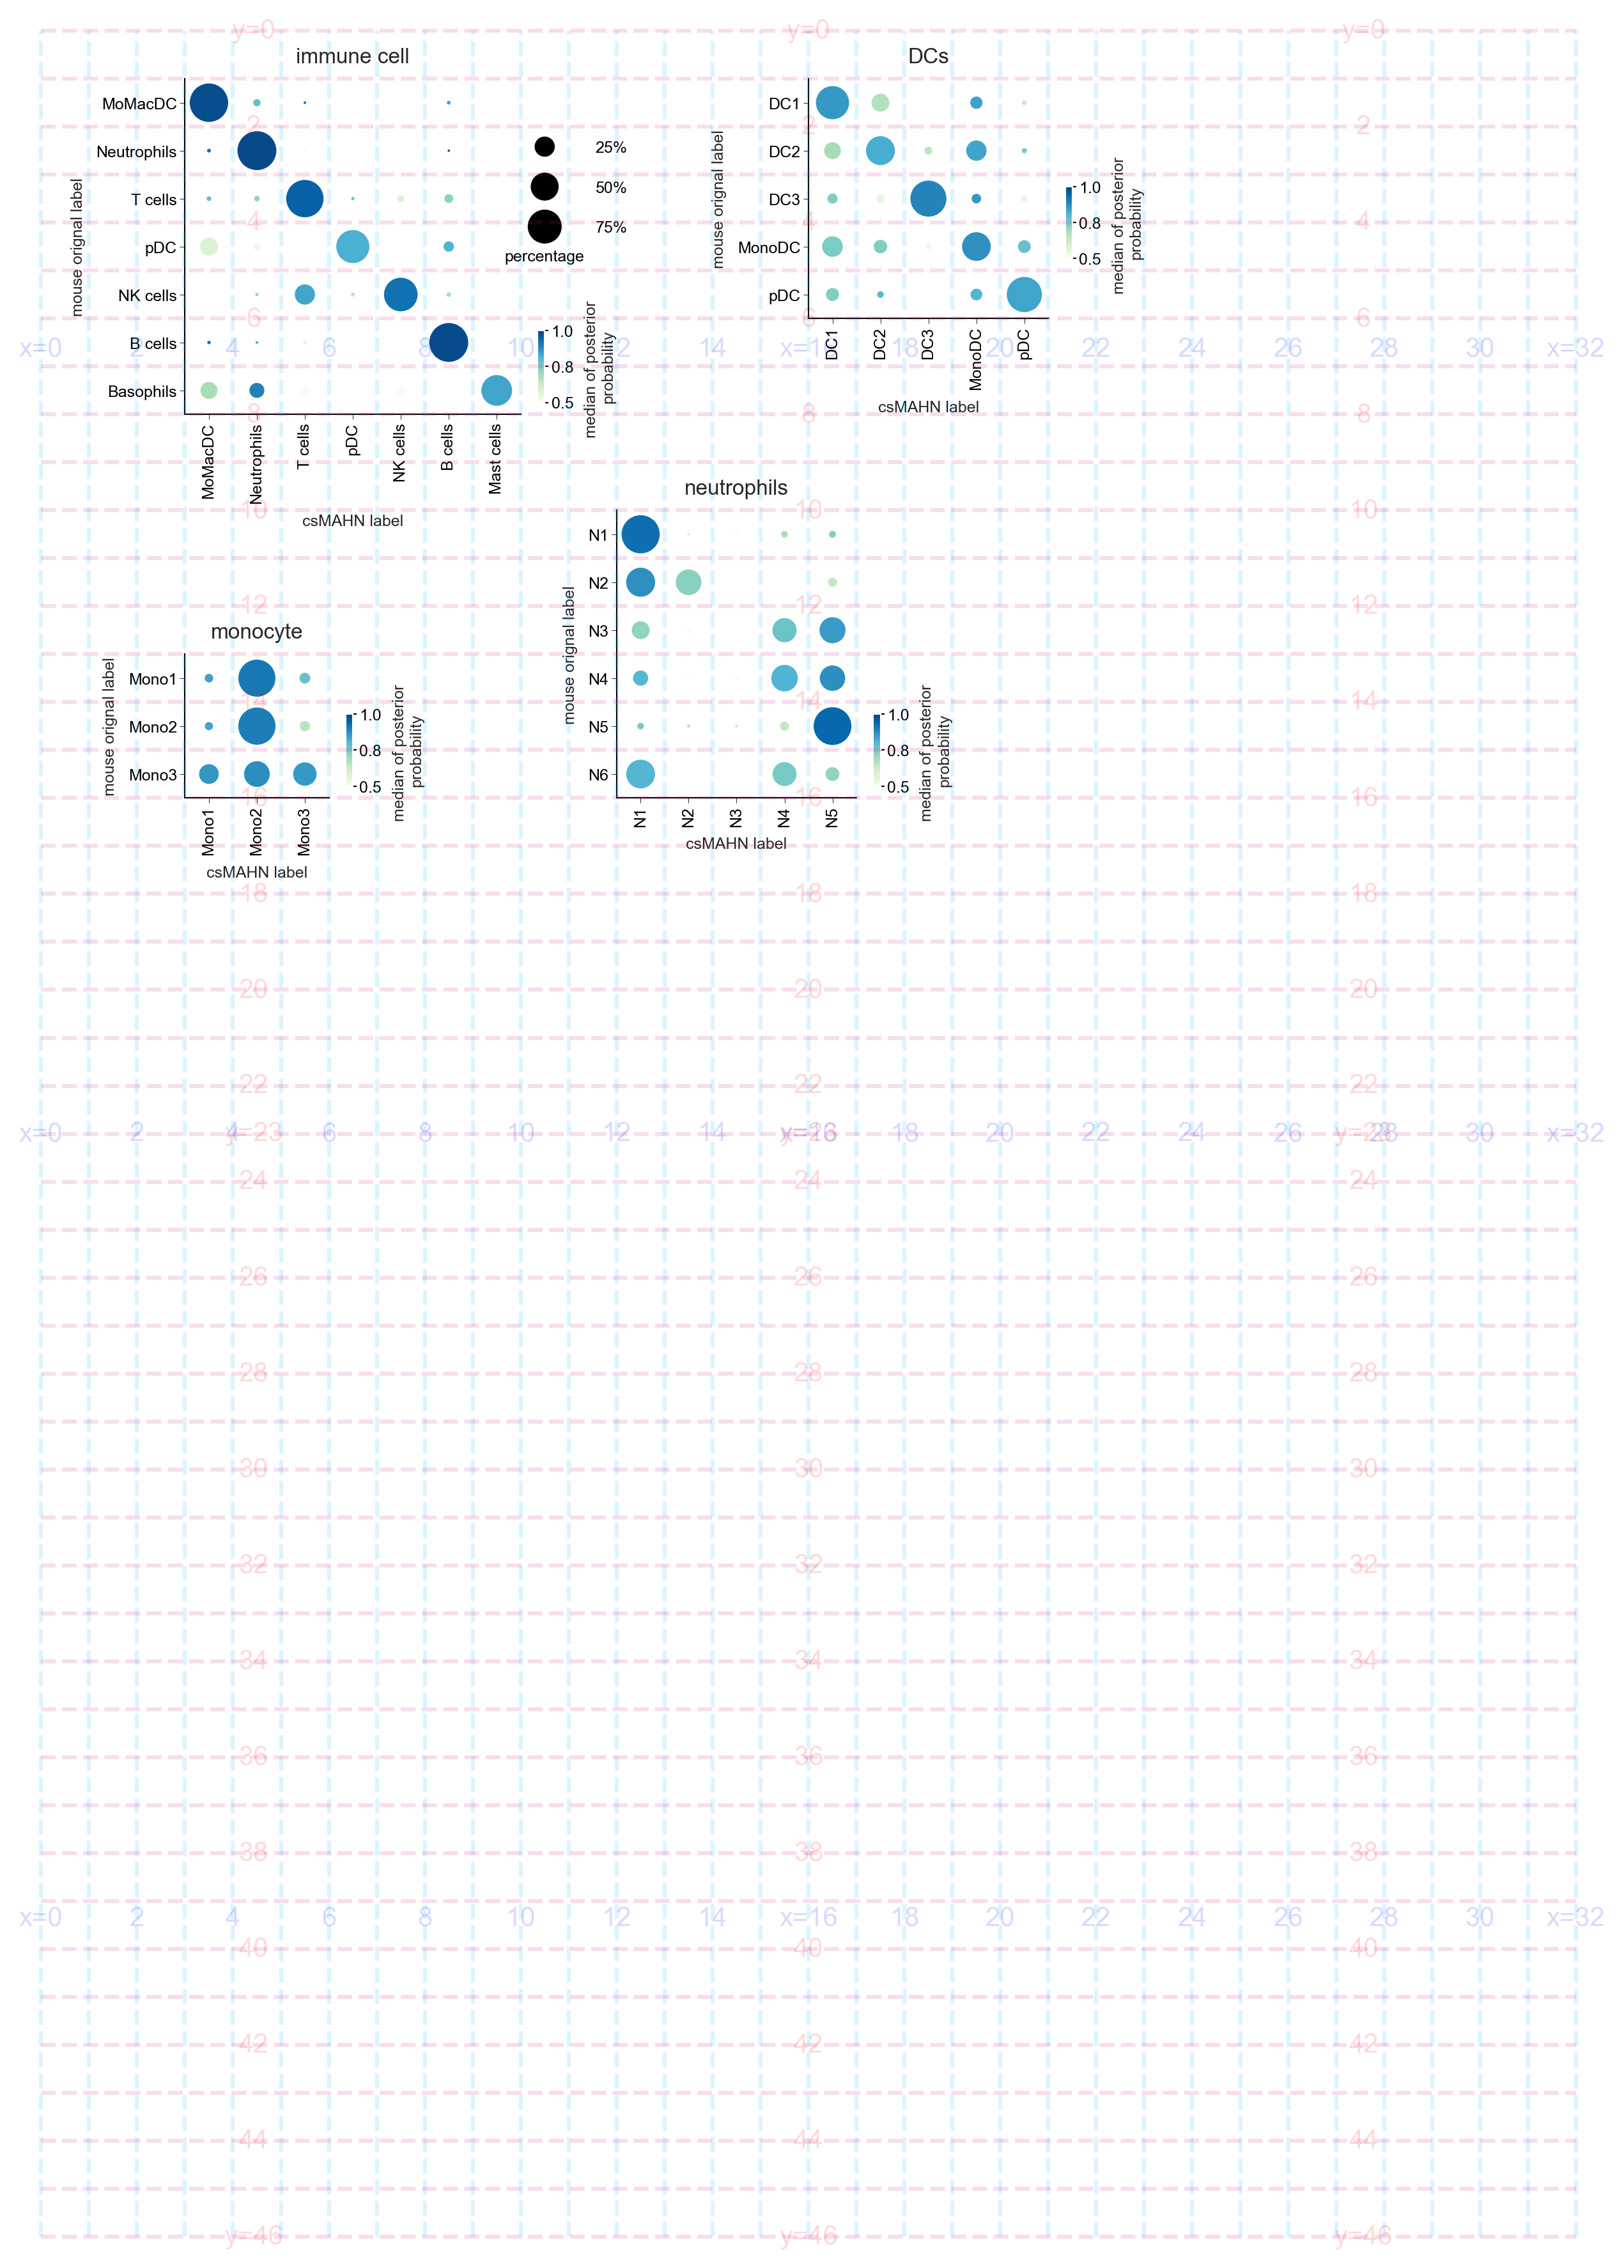

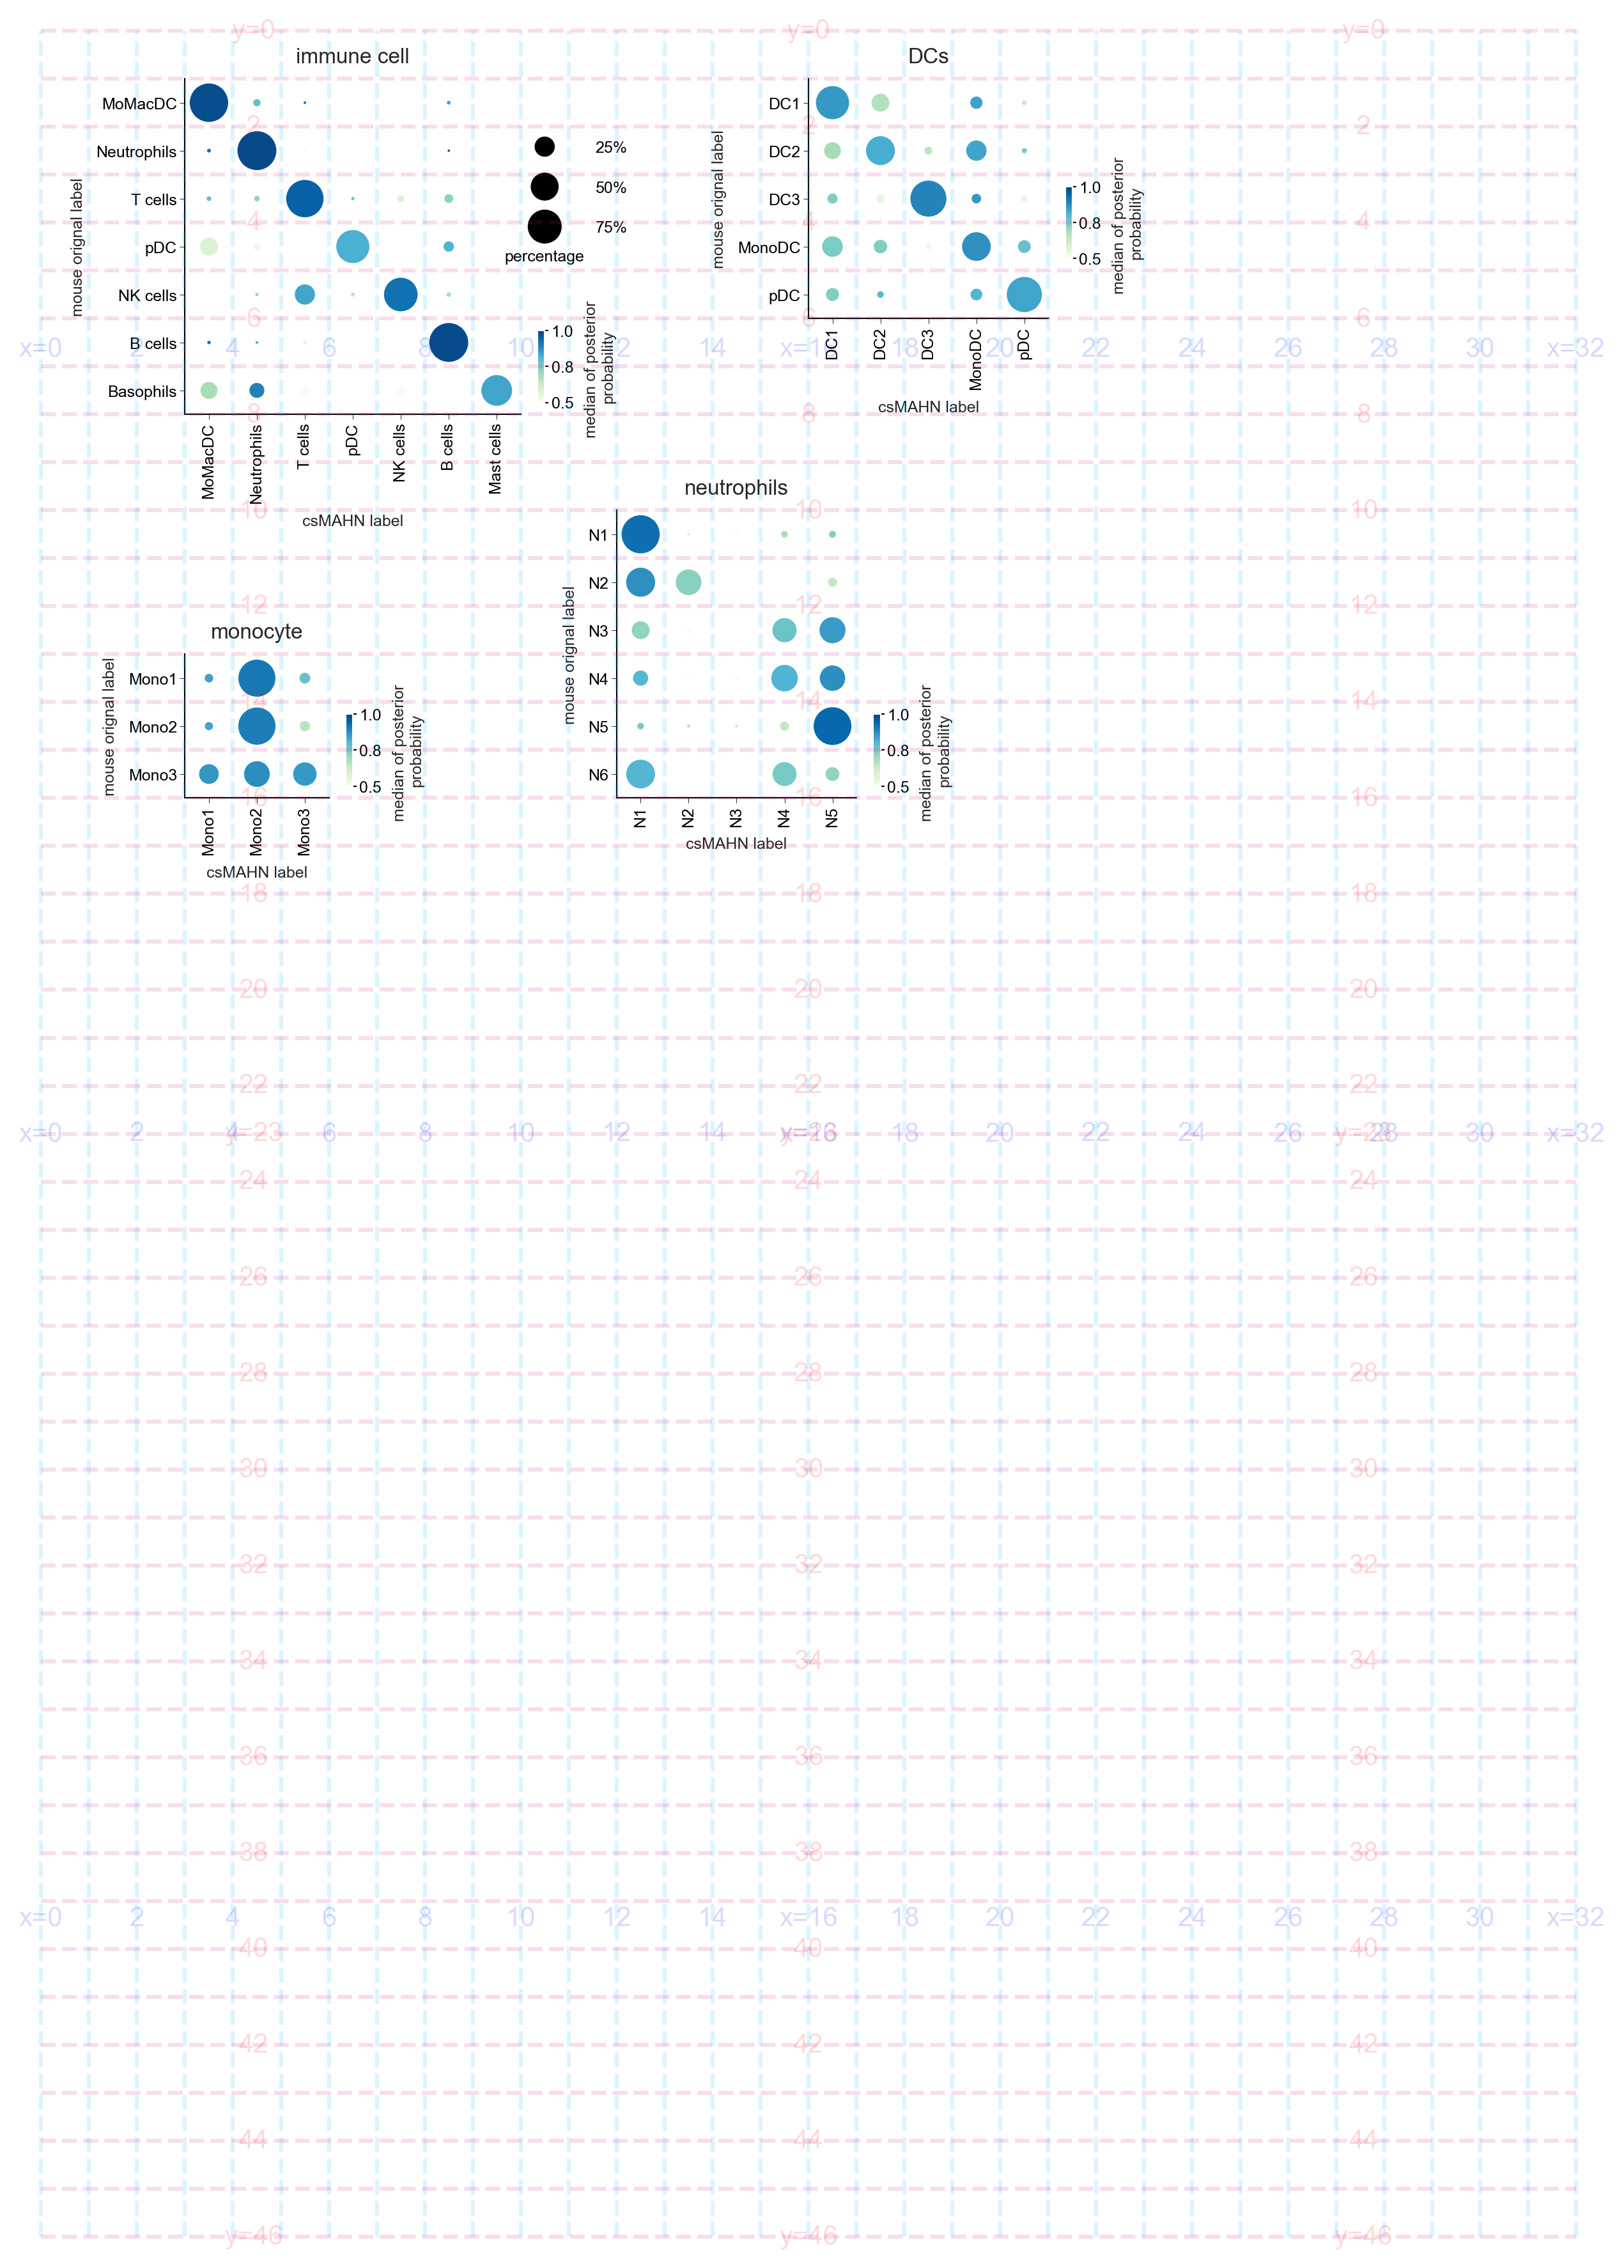

In [13]:
plt.close('all')
a4p = pl.figure.A4Page()
y = 1
with Block('posterior probability imm', context=dict(x=3, y=y,
                                                     cmap='GnBu', item='LCall')) as context:
    kw_cbar=dict(format='{x:.1f}', aspect=10,label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='MoMacDC,Neutrophils,T cells,pDC,NK cells,B cells,Mast cells'.split(','),
        order_row='MoMacDC,Neutrophils,T cells,pDC,NK cells,B cells,Basophils'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('immune cell')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')

    ax = a4p.add_ax(context.x+6.5, context.y+1, 2, 2.5, rc=update_dict(pl.rc_blank,
                                                                       {'ytick.labelright': True, 'xtick.labelbottom': True}))
    dotplot_marker_legend(ax, draw_cbar=False)
    ax = a4p.add_ax(context.x+6.5, context.y+5, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar,kw_cbar

with Block('posterior probability DCs',
           context=dict(x=16, y=y, cmap='GnBu', item='LCDCs')) as context:

    kw_cbar=dict(format='{x:.1f}', aspect=10, label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='DC1,DC2,DC3,MonoDC,pDC'.split(','),
        order_row='DC1,DC2,DC3,MonoDC,pDC'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('DCs')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')

    ax = a4p.add_ax(context.x+4.5, context.y+2, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar,kw_cbar
y += 12

with Block('posterior probability Mono', context=dict(x=3, y=y,cmap='GnBu', item='LCMono')) as context:
    kw_cbar = dict(format='{x:.1f}', aspect=10,label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='Mono1,Mono2,Mono3'.split(','),
        order_row='Mono1,Mono2,Mono3'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('monocyte')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')
    ax = a4p.add_ax(context.x+2.5, context.y+1, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar, kw_cbar

with Block('posterior probability Neu',
           context=dict(x=12, y=y-3, cmap='GnBu', item='LCNeu')) as context:
    kw_cbar=dict(format='{x:.1f}', aspect=10, label='median of posterior \nprobability')
    ppara = dict(
        data=ppara_adata[context.item].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col='N1,N2,N3,N4,N5'.split(','),
        order_row='N1,N2,N3,N4,N5,N6'.split(','))
    ax = a4p.add_ax(
        context.x, context.y, len(
            ppara['order_col']), len(
            ppara['order_row']), rc=pl.rc_frame)
    ax.set_title('neutrophils')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')
    ax = a4p.add_ax(context.x+4.5, context.y+4, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar,kw_cbar

# pl.tl_savefig(a4p.fig, '{}_{}_max_prob_median.svg'.format(item, model), p_pdf)
# pl.tl_savefig(a4p.fig, '{}_{}_max_prob_median.png'.format(item, model), p_pdf)

# a4p.save_as_pdf(p_pdf.joinpath('{}_{}_max_prob_median.pdf'.format(item, model)))
a4p.add_grid()
a4p.fig

# finish

In [14]:
print('\n[finish]\n'.center(100, '-'))

---------------------------------------------
[finish]
---------------------------------------------
